In [14]:
import json
import pprint
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# multi hot bag of bytes encoding
def path_to_vector(path):
    path_bytes = [i for i in bytes(path, 'ascii')]
    vector = [0 for i in range(256)]
    for i in path_bytes:
        vector[i] = 1
    return vector

def classifier_performance_metrics(classifier, X_test, y_test):
    y_test_pred = classifier.predict(X_test)
    matrix = confusion_matrix(y_test, y_test_pred)
    tn, fp, fn, tp = matrix.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp )
    recall = tp / (tp + fn)
    pprint.pprint({
        "tn": tn, 
        "fp": fp, 
        "fn": fn, 
        "tp": tp
    })
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall
    }

X = []
y = []

with open('data/paths-benign.txt', 'r') as f:
    for path in f.readlines():
        path = path.strip()
        X.append(path)
        y.append(0)

with open('data/paths-malicious.txt', 'r') as f:
    for path in f.readlines():
        path = path.strip()
        X.append(path)
        y.append(1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1234)

In [4]:
from sklearn.neural_network import MLPClassifier

nn_classifier = MLPClassifier(hidden_layer_sizes=(), random_state=1234)
nn_classifier.fit([path_to_vector(x) for x in X_train], y_train)

MLPClassifier(hidden_layer_sizes=(), random_state=1234)

<Axes: >

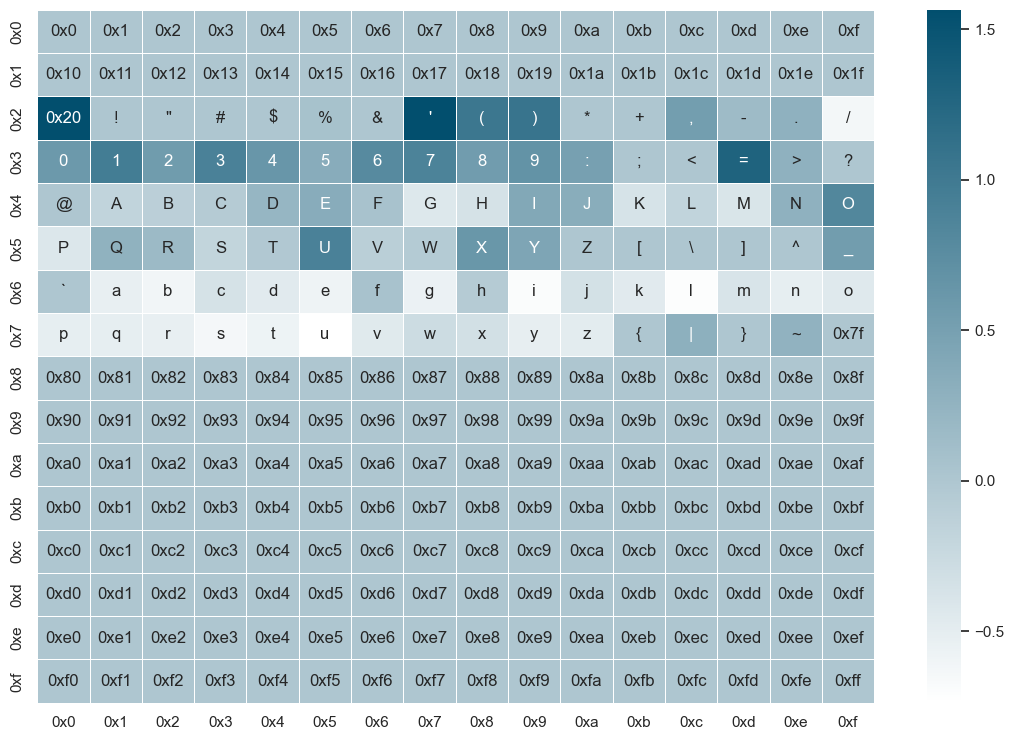

In [5]:


def render_printable(i):
    if i > 32 and i < 127:
        r = chr(i)
    else: 
        r = hex(i)
    return r

coefficients = [(render_printable(i), nn_classifier.coefs_[0][i]) for i in range(256)]

reshaped_keys = []
reshaped_values = []
for base in range(0,256,16):
    reshaped_keys.append([i[0] for i in coefficients[base:base+16]])
    reshaped_values.append([i[1][0] for i in coefficients[base:base+16]])

import matplotlib.pyplot as plt
import seaborn as sns
colors = ["#ffffff", "#024f6e"]
sns.set_theme()
my_cmap = sns.blend_palette(colors, as_cmap = True)

# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(13.5, 9))
sns.heatmap(
    reshaped_values, 
    annot=reshaped_keys, 
    fmt='', 
    linewidths=.5, 
    ax=ax, 
    cmap=my_cmap,
    yticklabels=[hex(i) for i in range(0,16)],
    xticklabels=[hex(i) for i in range(0,16)]
)

In [15]:
sorted_coefficients = sorted(coefficients, key = lambda i: -i[1])
print("Top ten characters: ")
pprint.pprint(sorted_coefficients[:10])
print("Bottom ten characters: ")
pprint.pprint(sorted_coefficients[-10:])

Top ten characters: 
[('0x20', array([1.5640511])),
 ("'", array([1.55660452])),
 ('=', array([1.29466259])),
 (')', array([1.07534899])),
 ('(', array([1.03737089])),
 ('1', array([0.96597745])),
 ('3', array([0.89979062])),
 ('U', array([0.89895137])),
 ('7', array([0.88764806])),
 ('O', array([0.83535017]))]
Bottom ten characters: 
[('a', array([-0.52793128])),
 ('g', array([-0.55777446])),
 ('t', array([-0.57136618])),
 ('e', array([-0.57752761])),
 ('b', array([-0.60997791])),
 ('/', array([-0.62234937])),
 ('s', array([-0.63163772])),
 ('i', array([-0.69271472])),
 ('l', array([-0.71074806])),
 ('u', array([-0.73811298]))]


{'fn': 4, 'fp': 0, 'tn': 2844, 'tp': 11}
{'fn': 4, 'fp': 0, 'tn': 2844, 'tp': 11}
{'fn': 2, 'fp': 0, 'tn': 2844, 'tp': 13}
{'fn': 7, 'fp': 0, 'tn': 2844, 'tp': 8}
{'fn': 6, 'fp': 0, 'tn': 2844, 'tp': 9}
{'fn': 6, 'fp': 0, 'tn': 2844, 'tp': 9}
Neural network:
{'accuracy': 0.9986009094088842, 'precision': 1.0, 'recall': 0.7333333333333333}
Space Classifier:
{'accuracy': 0.9986009094088842, 'precision': 1.0, 'recall': 0.7333333333333333}
Quote Classifier:
{'accuracy': 0.9993004547044421, 'precision': 1.0, 'recall': 0.8666666666666667}
Equals Classifier:
{'accuracy': 0.9975515914655474, 'precision': 1.0, 'recall': 0.5333333333333333}
RightParenthesis Classifier:
{'accuracy': 0.9979013641133263, 'precision': 1.0, 'recall': 0.6}
LeftParenthesis Classifier:
{'accuracy': 0.9979013641133263, 'precision': 1.0, 'recall': 0.6}


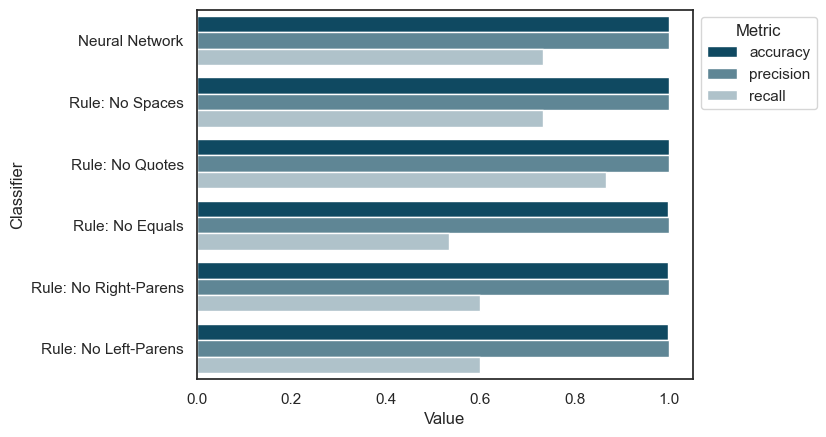

In [35]:
from sklearn.base import BaseEstimator, ClassifierMixin

class SpaceClassifier(BaseEstimator, ClassifierMixin):
    def predict(self, X, y=None):
        return [1 if ' ' in i else 0 for i in X]

class QuoteClassifier(BaseEstimator, ClassifierMixin):
    def predict(self, X, y=None):
        return [1 if "'" in i else 0 for i in X]

class EqualsClassifier(BaseEstimator, ClassifierMixin):
    def predict(self, X, y=None):
        return [1 if "=" in i else 0 for i in X]

class LeftParenthesisClassifier(BaseEstimator, ClassifierMixin):
    def predict(self, X, y=None):
        return [1 if "(" in i else 0 for i in X]

class RightParenthesisClassifier(BaseEstimator, ClassifierMixin):
    def predict(self, X, y=None):
        return [1 if ")" in i else 0 for i in X]

space_classifier = SpaceClassifier()
quote_classifier = QuoteClassifier()
equals_classifier = EqualsClassifier()
right_parenthesis_classifier = RightParenthesisClassifier()
left_parenthesis_classifier = LeftParenthesisClassifier()

nn_classifier_performance = classifier_performance_metrics(nn_classifier, [path_to_vector(x) for x in X_test], y_test)
space_classifier_performance = classifier_performance_metrics(space_classifier, X_test, y_test)
quote_classifier_performance = classifier_performance_metrics(quote_classifier, X_test, y_test)
equals_classifier_performance = classifier_performance_metrics(equals_classifier, X_test, y_test)
right_parenthesis_classifier_performance = classifier_performance_metrics(right_parenthesis_classifier, X_test, y_test)
left_parenthesis_classifier_performance = classifier_performance_metrics(left_parenthesis_classifier, X_test, y_test)

print("Neural network:")
pprint.pprint(nn_classifier_performance)

print("Space Classifier:")
pprint.pprint(space_classifier_performance)

print("Quote Classifier:")
pprint.pprint(quote_classifier_performance)

print("Equals Classifier:")
pprint.pprint(equals_classifier_performance)

print("RightParenthesis Classifier:")
pprint.pprint(right_parenthesis_classifier_performance)

print("LeftParenthesis Classifier:")
pprint.pprint(left_parenthesis_classifier_performance)

import pandas as pd
colors = ["#ffffff", "#024f6e"][::-1]
sns.set_theme(style='white')
palette = sns.blend_palette(colors, n_colors=4)

rows = []
for metric, value in nn_classifier_performance.items():
    rows.append(["Neural Network", metric, value])
for metric, value in space_classifier_performance.items():
    rows.append(["Rule: No Spaces", metric, value])
for metric, value in quote_classifier_performance.items():
    rows.append(["Rule: No Quotes", metric, value])
for metric, value in equals_classifier_performance.items():
    rows.append(["Rule: No Equals", metric, value])
for metric, value in right_parenthesis_classifier_performance.items():
    rows.append(["Rule: No Right-Parens", metric, value])
for metric, value in left_parenthesis_classifier_performance.items():
    rows.append(["Rule: No Left-Parens", metric, value])
df = pd.DataFrame(rows, columns=["Classifier", "Metric", "Value"])
df.head()

ax = sns.barplot(
    x="Value", 
    y="Classifier",
    hue='Metric',
    data=df,
    palette=palette
)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))